In [1]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import metpy
import scipy.stats as sts
import re
from glob import glob
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.convection import dry_profile_temp, potential_temp
from isca_tools.convection.base import convection_neutral_profile, lcl_temp_bolton, lcl_sigma_bolton_simple
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils.base import weighted_RMS, insert_to_array
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, lapse_moist, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure, \
    get_var_at_plev, get_ds_in_pressure_range
from isca_tools.thesis.lapse_integral_simple import get_temp_2_layer_approx, fitting_2_layer_xr
from isca_tools.thesis.mod_parcel_theory import get_scale_factor_theory_numerical
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
from isca_tools.thesis.adiabat_theory2 import get_temp_adiabat_surf, get_temp_adiabat
from isca_tools.thesis.profile_fitting import get_mse_env, get_lnb_lev_ind, get_mse_prof_rms
from isca_tools.utils.ds_slicing import lat_lon_coord_slice
from isca_tools.thesis.adiabat_theory import get_theory_prefactor_terms
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
from typing import Tuple, Optional
import os
from sklearn.decomposition import PCA

from isca_tools.utils.xarray import flatten_to_numpy, unflatten_from_numpy, convert_ds_dtypes
from isca_tools.papers.byrne_2021 import get_quant_ind

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

## Load Data
Once compute the parcel temperature at $p_{FT}$, I save the dataset as takes around 8 minutes to compute.

In [3]:
# Info for loading in data
exp_dir = {'aquaplanet': 'tau_sweep/aquaplanet/depth=1/',
           'land': 'tau_sweep/land/meridional_band/depth=1/bucket_evap/'}
kappa_names = ['k=1_2m', 'k=1_5_2m']
# kappa_names = ['k=1_2m']
# kappa_names = ['k=1_5_2m']
n_kappa = len(kappa_names)

region = 'tropics'
hemisphere = 'north'
season = 'summer'
lat_min = 0
lat_max = 20
lat_max = 4

if hemisphere == 'north':
    lat_min = np.abs(lat_min)
    lat_max = np.abs(lat_max)
else:
    lat_min = -np.abs(lat_max)
    lat_max = -np.abs(lat_min)

season_months = {'summer': {'tropics': {'north': [5, 6, 7, 8, 9, 10],
                                        'south': [11, 12, 1, 2, 3, 4]},
                            'not_tropics': {'north': [6, 7, 8],
                                            'south': [12, 1, 2]}},
                 'winter': {}}
for key in ['tropics', 'not_tropics']:
    season_months['winter'][key] = {'north': season_months['summer'][key]['south'],
                                    'south': season_months['summer'][key]['north']}

# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'cape',
            'ps']  # only keep variables required to compute relative humidity and MSE
use_time_start = 360 * 2

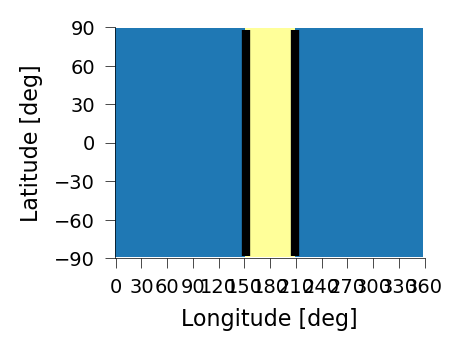

In [4]:
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir['land'],
                              kappa_names[0].replace('_2m', ''), 'land.nc')

fig, ax = plt.subplots(1, 1)
fig_resize(fig, 2)
isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]  # get the longitude coordinates of land

### Convert ds to CESM like data
Below I convert the variable names in the dataset into those expected from CESM.

In [5]:
ds = {key: [] for key in exp_dir}
albedo = {key: [] for key in exp_dir}
tau_sw = {key: [] for key in exp_dir}
tau_lw = {key: [] for key in exp_dir}
with tqdm(total=n_kappa * 2, position=0, leave=True) as pbar:
    for key in exp_dir:
        for j in range(n_kappa):
            ds_use = isca_tools.load_dataset(exp_dir[key] + kappa_names[j]).sel(time=slice(use_time_start, np.inf))[
                var_keep]
            ds_use['sphum'] = ds_use.sphum.isel(pfull=-1)  # only keep surface SPHUM

            ds_use = ds_use.sel(lat=slice(lat_min, lat_max))
            # Only keep land longitudes - for aquaplanet, does not matter which we keep
            ds_use = ds_use.isel(lon=np.where(np.isin(ds_use.lon, np.unique(lon_land)))[0])

            # Only load in months of interest for season and hemisphere
            ds_use = isca_tools.utils.annual_time_slice(ds_use, season_months[season][region][hemisphere])
            # Stack longitude and time into new sample dimension to match CESM
            # ds_use = ds_use.stack(sample=("lon", "time"), create_index=False).chunk(dict(sample=-1))
            ds[key] += [ds_use.load()]

            namelist = isca_tools.load_namelist(exp_dir[key] + kappa_names[j])  # Need this for albedo_value
            albedo[key] += [namelist['mixed_layer_nml']['albedo_value']]
            tau_sw[key] += [namelist['two_stream_gray_rad_nml']['atm_abs']]
            tau_lw[key] += [namelist['two_stream_gray_rad_nml']['odp']]
            pbar.update(1)
        ds[key] = xr.concat(ds[key], dim=xr.DataArray(tau_lw[key], dims="tau_lw", name='tau_lw'))

# Concatenate ds along surf dimension
ds = xr.concat([ds[key] for key in ds],
               dim=xr.DataArray([key for key in ds], dims="surf", name='surf'))

# Rename variables to match CESM
ds = ds.rename({'temp': 'T', 'sphum': 'QREFHT',
                'height': 'Z3', 'cape': 'CAPE', 'ps': 'PS',
                'pfull': 'lev'})

# sigma_half reflects ds_us.pfull (starts with 0 - space, ends with 1 - surface)
sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
# hybm are sigma full levels
hybm = np.convolve(sigma_levels_half, np.ones(2) / 2,
                   'valid')  # sigma levels corresponding to pressure levels
ds['hybm'] = ds.lev * 0 + hybm  # convert to xarray

# choose lowest model level as REFHT
ds['TREFHT'] = ds.T.isel(lev=-1)
ds['ZREFHT'] = ds.Z3.isel(lev=-1)
ds['PREFHT'] = ds.PS * ds.hybm.isel(lev=-1)

  0%|          | 0/4 [00:00<?, ?it/s]

### Compute variables for lapse fitting
Below, I compute the LCL and FT variables required to do the vertical temperature profile fitting.

In [6]:
def get_P(ds):
    return ds.PS * ds.hybm


temp_lcl_bolton_use = float(np.ceil(ds.TREFHT.median()))

ds['mse_REFHT'] = moist_static_energy(ds.TREFHT, ds.QREFHT, ds.ZREFHT)
ds['rh_REFHT'] = ds.QREFHT / sphum_sat(ds.TREFHT, ds.PREFHT)
ds['p_lcl'] = lcl_sigma_bolton_simple(ds.rh_REFHT, temp_lcl_bolton_use) * ds.PREFHT
# ds['T_lcl_parcel'] =
ds['T_lcl_env'] = get_var_at_plev(ds.T, get_P(ds), ds.p_lcl)
# ds['mse_env'] = get_mse_env(ds.T, ds.P, ds.Z3, ds.p_lcl, sphum_below_lcl=ds.QREFHT)

In [7]:
p_ft = 500 * 100
ds['T_ft_env'] = get_var_at_plev(ds.T, get_P(ds), p_ft)
ds['Z_ft_env'] = get_var_at_plev(ds.Z3, get_P(ds), p_ft)
ds['mse_ft_env_sat'] = moist_static_energy(ds.T_ft_env, sphum_sat(ds.T_ft_env, p_ft), ds.Z_ft_env)

## Analysis as function of temperature quantile, $x$
Next, for a range of `TREFHT` quantiles, I first get the `ds` conditioned on these temperatures.

Then I compute the parameters and error for the `const` and `mod_parcel` lapse rate profiles on these sample days.

In [8]:
def get_ds_quant_single_coord(ds, quant=90, range_below=0.5, range_above=0.5):
    quant_mask = get_quant_ind(ds.TREFHT.squeeze(), quant, range_below, range_above, av_dim=['lon', 'time'],
                               return_mask=True)
    ds_use = ds.where(quant_mask).stack(sample=("lon", "time"), create_index=False).chunk(dict(sample=-1))
    ds_use = ds_use.load()
    ds_use = ds_use.where(ds_use.TREFHT > 0, drop=True)
    return ds_use


def get_ds_quant(ds, quant=90, range_below=0.5, range_above=0.5, n_keep=None):
    quant_mask = get_quant_ind(ds.TREFHT, quant, range_below, range_above, av_dim=['lon', 'time'], return_mask=True)
    # n_keep is so can concat ds of different quantiles. A given quant range will give slightly different numbers of samples at each location.
    # Through providing n_keep, you can ensure the number is always the same.
    n_keep_max = int(quant_mask.sum(dim=['lon', 'time']).min())
    if n_keep is None:
        n_keep = n_keep_max
    if n_keep > n_keep_max:
        raise ValueError(f'n_keep={n_keep} > n_keep_max={n_keep_max}')
    ds_out = []
    for i in range(ds.tau_lw.size):
        ds_use_j = []
        for j in range(ds.surf.size):
            ds_use_k = []
            for k in range(ds.lat.size):
                ds_use_k.append(
                    get_ds_quant_single_coord(ds.isel(tau_lw=i, surf=j, lat=k, drop=True), quant, range_below,
                                              range_above).isel(sample=slice(0, n_keep)))
            ds_use_k = xr.concat(ds_use_k, dim=ds.lat)
            ds_use_j.append(ds_use_k)
        ds_use_j = xr.concat(ds_use_j, dim=ds.surf)
        ds_out.append(ds_use_j)
    ds_out = xr.concat(ds_out, dim=ds.tau_lw)
    return ds_out

In [9]:
quant_range = 0.5
n_sample = 180
# n_sample = 10
quant_all = np.arange(1, 100, 7)
ds_quant = []
for i in tqdm(quant_all):
    ds_quant.append(get_ds_quant(ds, i, quant_range, quant_range, n_sample))
ds_quant = xr.concat(ds_quant, dim=xr.DataArray(quant_all, dims="quant", name='quant'))

  0%|          | 0/15 [00:00<?, ?it/s]

In [10]:
def get_lapse_fitting_info(ds):
    ds.attrs['n_lev_above_integral'] = 3
    var_names = ['lapse', 'integral', 'error']

    with tqdm(total=2, position=0, leave=True) as pbar:
        for key in ['const', 'mod_parcel']:
            var = fitting_2_layer_xr(ds.T, get_P(ds), ds.TREFHT, ds.PREFHT, ds.rh_REFHT, ds.T_ft_env,
                                     p_ft, n_lev_above_upper2_integral=ds.n_lev_above_integral,
                                     method_layer2=key, temp_surf_lcl_calc=temp_lcl_bolton_use)
            # Must include fillna as inf to deal with all nan slice.
            for k, key2 in enumerate(var_names):
                ds[f'{key}1_{key2}'] = var[k]
            pbar.update(1)
    return ds

In [11]:
ds_quant = get_lapse_fitting_info(ds_quant)

  0%|          | 0/2 [00:00<?, ?it/s]

### Equation for $\epsilon$ in terms of lapse rate fitting parameters
In `duffield_byrne_2025`, there is a term $\epsilon = h_s - h_{FT}^*$ which quantifies CAPE.

In this reimagining of the vertical coupling between surface and `FT` level, we obtain a new equation for $\epsilon$ in terms of lapse rate fitting parameters:
* $\eta_{D}$ such that lapse rate below the LCL, $\Gamma(p) = \Gamma_D + \eta_{D}$
* $\eta_{M}$ such that lapse rate above the LCL, $\Gamma(p) = \Gamma_M(p) + \eta_{M}$, where $\Gamma_M(p)$ is the moist adiabatic lapse rate at level $p$.

The final equation is:

$\epsilon = -A_z + A_{FT,p} - A_{s,p} + \beta_{FT1}(\sigma_{FT}^{-R\eta_M /g}r_s^{R\eta_M \nu /g} - 1)T_{FT} - \beta_{s1} (r_s^{R\eta_D/g} - 1)T_s$

Where:
* $A_z$, $\beta_{FT1}$ and $\beta_{s1}$ are as defined in `duffield_byrne_2025`.
* $\nu = \frac{c_p}{2840 R} \frac{(T_{s,ref} - 55)^2}{T_{s,ref}}$ is the exponent used such that $\sigma_{LCL} = r_s^{\nu}$. The reference surface temperature used, is set to 300K here.
* $A_{FT,p}$ and $A_{s,p}$ are the errors in the taylor expansion about the environmental $T_{FT}$ and $T_{s}$ respectively.

Below, we do a sanity check that this equation is correct.

If `do_taylor_expansion=True`, this simplifies to:

$\epsilon = -A_z + A_{p} + \beta_{FT1}\frac{R}{g}\eta_M\ln(\frac{r_s^{\nu}}{\sigma_{FT}})T_{FT} - \beta_{s1} \frac{R\nu}{g}\eta_D \ln (r_s) T_s$

where $A_p = A_{FT,p} - A_{s,p}$ plus additional terms due to taylor expansion about $\eta_M = 0$ and $\eta_D=0$.

In [24]:
ds_sf = ds_quant[['TREFHT', 'PREFHT', 'rh_REFHT', 'T_ft_env', 'mod_parcel1_lapse']].isel(surf=0, lat=0).mean(dim='sample')
ds_sf['lapse_mod_D'] = ds_sf['mod_parcel1_lapse'].isel(layer=0)/1000 - lapse_dry
ds_sf['lapse_mod_M'] = ds_sf['mod_parcel1_lapse'].isel(layer=1)/1000
ds_sf = ds_sf.drop_vars('mod_parcel1_lapse')
ds_sf = ds_sf.transpose('tau_lw', 'quant')
ds_sf = ds_sf.rename({'TREFHT': 'temp_surf', 'PREFHT': 'p_surf', 'rh_REFHT': 'rh_surf', 'T_ft_env': 'temp_ft',
                      'tau_lw': 'co2'})
for key in ['temp_surf', 'p_surf', 'rh_surf', 'lapse_mod_D', 'lapse_mod_M']:
    ds_sf[key+'_ref'] = ds_sf[key].median(dim='quant')
    if 'lapse' in key:
        ds_sf[key+'_ref'] = np.abs(ds_sf[key+'_ref'] * 0)       # for lapse, ref value is 0
    elif key != 'temp_surf':
        # For rh and pressure, keep at colder climate ref
        ds_sf[key+'_ref'] = ds_sf[key+'_ref']*0 + ds_sf[key+'_ref'].isel(co2=0)

In [25]:
def apply_scale_factor(ds, p_ft=p_ft):
    """Apply get_scale_factor_theory_numerical to an xarray.Dataset."""

    out_main, out_linear, out_dict = xr.apply_ufunc(
        get_scale_factor_theory_numerical,
        ds["temp_surf_ref"],        # (co2)
        ds["temp_surf"],      # (co2, quant)
        ds["rh_surf_ref"],                # (co2)
        ds["rh_surf"],              # (co2, quant)
        ds["temp_ft"],        # (co2, quant)
        ds["lapse_mod_D"],    # (co2, quant)
        ds["lapse_mod_M"],    # (co2, quant)
        p_ft,             # (co2) or scalar
        ds["p_surf_ref"],           # (co2) or scalar
        ds["p_surf"],     # (co2, quant) or None
        ds["lapse_mod_D_ref"],  # (co2) or None
        ds["lapse_mod_M_ref"],  # (co2) or None
        kwargs=dict(
            temp_surf_lcl_calc=300
        ),
        input_core_dims=[
            ["co2"],        # temp_surf_ref
            ["co2", "quant"],
            ["co2"],
            ["co2", "quant"],
            ["co2", "quant"],
            ["co2", "quant"],
            ["co2", "quant"],
            [],        # p_ft_ref
            ["co2"],        # p_surf_ref
            ["co2", "quant"],
            ["co2"],
            ["co2"],
        ],
        output_core_dims=[
            ["quant"],   # result array
            ["quant"],
            []                  # dict-of-arrays (broadcast to co2)
        ],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, float, object],
    )

    # Expand the dictionary output entries into proper DataArrays
    dict_ds = {'scale_factor': (ds['temp_surf'].isel(co2=1) - ds['temp_surf'].isel(co2=0)
                                ) / (ds['temp_surf_ref'].isel(co2=1) - ds['temp_surf_ref'].isel(co2=0))}
    for key in out_dict.item().keys():
        dict_ds[key] = xr.DataArray(
            out_dict.item()[key],
            coords=dict(quant=ds.quant),
            dims=("quant"),
        )
    return xr.Dataset({"scale_factor_sum": out_main, "scale_factor_linear": out_linear, **dict_ds})

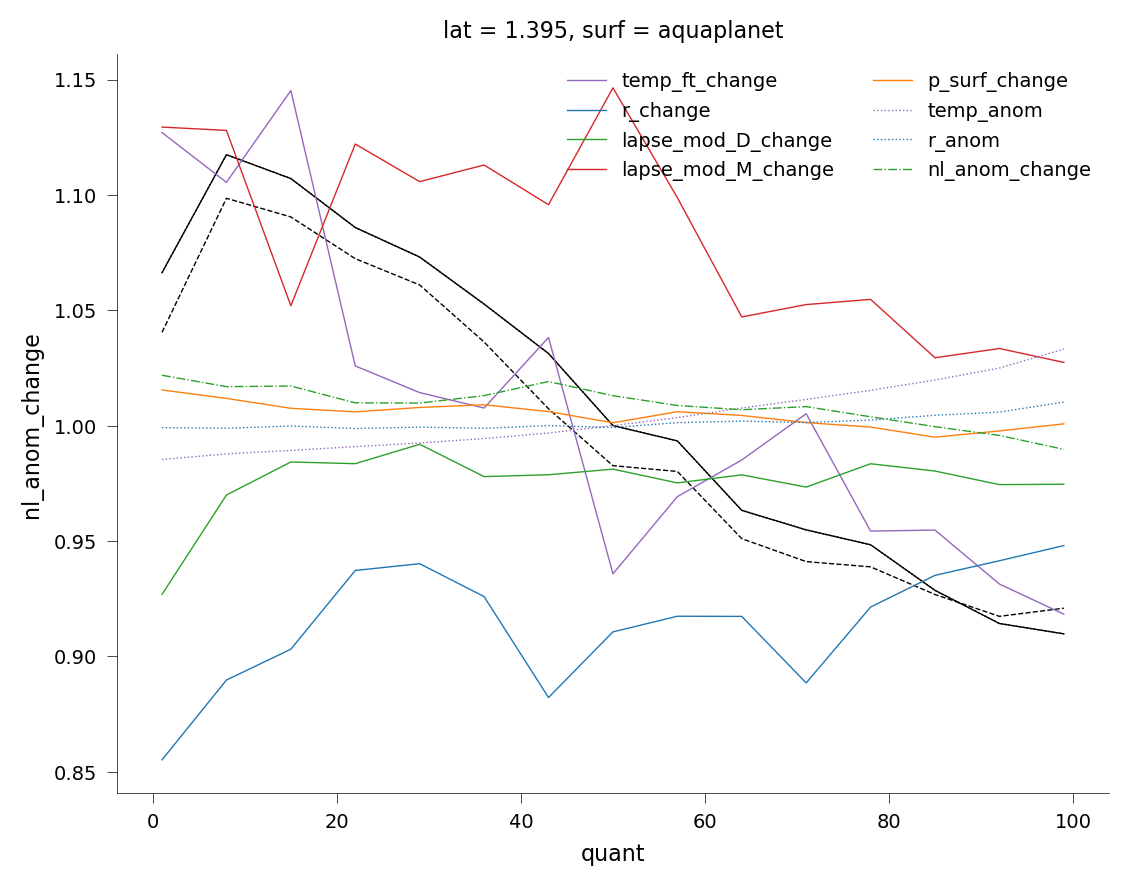

In [27]:
style_map = {
    # --- reference change (dashed) ---
    "r_ref_change":              ("C0", "--"),
    "p_surf_ref_change":         ("C1", "--"),
    "lapse_mod_D_ref_change":    ("C2", "--"),
    "lapse_mod_M_ref_change":    ("C3", "--"),

    # --- change (solid) ---
    "temp_ft_change":            ("C4", "-"),
    "r_change":                  ("C0", "-"),
    "lapse_mod_D_change":        ("C2", "-"),
    "lapse_mod_M_change":        ("C3", "-"),
    "p_surf_change":             ("C1", "-"),
    "error_av_change":           ("C5", "-"),

    # --- anomalies (dotted) ---
    "temp_anom":                 ("C4", ":"),
    "r_anom":                    ("C0", ":"),
    "lapse_mod_D_anom":          ("C2", ":"),
    "lapse_mod_M_anom":          ("C3", ":"),
    "p_surf_anom":               ("C1", ":"),

    # nl
    "nl_change":                 ("C0", "-."),
    "nl_anom":                   ("C1", "-."),
    "nl_anom_change":            ("C2", "-."),
}

ds_out = apply_scale_factor(ds_sf)
# ds_out['scale_factor_linear'] = ds_out['scale_factor']
# ds_out['scale_factor'] = (ds_sf['temp_surf'].isel(co2=1) - ds_sf['temp_surf'].isel(co2=0)
#                           ) / (ds_sf['temp_surf_ref'].isel(co2=1) - ds_sf['temp_surf_ref'].isel(co2=0))
ds_out.scale_factor.plot(color='k')
ds_out.scale_factor_sum.plot(color='k', linestyle=':')
ds_out.scale_factor_linear.plot(color='k', linestyle='--')
for key in ds_out:
    if ('scale_factor' in key) or (np.abs(ds_out[key]-1).max()<0.01):
        continue
    ds_out[key].plot(label=key, color=style_map[key][0], linestyle=style_map[key][1])
plt.legend(ncol=2)
plt.show()
# apply_scale_factor(ds_sf)['p_surf_change'].plot()
# apply_scale_factor(ds_sf)['temp_anom'].plot()
# apply_scale_factor(ds_sf)['r_change'].plot()
# apply_scale_factor(ds_sf)['lapse_mod_D_anom'].plot()

In [15]:
ds_out['error_av_change']

<xarray.DataArray 'error_av_change' (quant: 15)> Size: 120B
array([0.998823  , 1.00116226, 1.00093733, 1.00385748, 1.00270765,
       1.00242398, 1.00271421, 1.00222168, 1.00192082, 1.00304643,
       1.00189842, 1.00330411, 1.00036514, 0.99943881, 0.99969867])
Coordinates:
    lat      float64 8B 1.395
    surf     <U10 40B 'aquaplanet'
  * quant    (quant) int64 120B 1 8 15 22 29 36 43 50 57 64 71 78 85 92 99

In [16]:
epsilon = ds_quant.mse_REFHT - ds_quant.mse_ft_env_sat
z_diff = g * (ds_quant.Z_ft_env - ds_quant.ZREFHT)
R_mod, _, _, beta_ft1, _, _, _ = get_theory_prefactor_terms(ds_quant.T_ft_env, ds_quant.PREFHT, p_ft)
beta_ft1 = beta_ft1 / 1000
beta_s1 = get_theory_prefactor_terms(ds_quant.TREFHT, ds_quant.PREFHT, p_ft, sphum=ds_quant.QREFHT)[3] / 1000
z_diff_theory = R_mod * (ds_quant.TREFHT + ds_quant.T_ft_env)
z_error = (z_diff - z_diff_theory) / 1000  # units of kJ/kg

In [17]:
ds_quant['TREFHT_parcel'] = ds_quant['T_lcl_env'] * (ds_quant.p_lcl / ds_quant.PREFHT) ** (-R * lapse_dry / g)
ds_quant['T_ft_parcel'] = xr.apply_ufunc(get_temp_adiabat, ds_quant['TREFHT_parcel'],
                                         ds_quant.rh_REFHT * sphum_sat(ds_quant['TREFHT_parcel'], ds_quant.PREFHT),
                                         ds_quant.PREFHT,
                                         input_core_dims=[[], [], []], vectorize=True, kwargs={'pressure_ft': p_ft})

In [18]:
do_taylor_expansion = True      # whether to do taylor expansion in derivation of new form of epsilon

In [19]:
mse_mod_ft_parcel = ((c_p + R_mod) * ds_quant['T_ft_parcel'] + L_v * sphum_sat(ds_quant['T_ft_parcel'], p_ft)) / 1000
mse_mod_ft_env = ((c_p + R_mod) * ds_quant['T_ft_env'] + L_v * sphum_sat(ds_quant['T_ft_env'], p_ft)) / 1000
exponent_use = R * (ds_quant['mod_parcel1_lapse'].isel(layer=1) / 1000) / g
if do_taylor_expansion:
    mse_mod_ft_parcel_approx = mse_mod_ft_env + beta_ft1 * ds_quant['T_ft_env'] * exponent_use * np.log(
        (ds_quant['p_lcl'] / ds_quant.PREFHT) / (p_ft / ds_quant.PREFHT))
else:
    mse_mod_ft_parcel_approx = mse_mod_ft_env + beta_ft1 * ((ds_quant['p_lcl'] / ds_quant.PREFHT) ** exponent_use *
                                                            (p_ft / ds_quant.PREFHT) ** (-exponent_use)
                                                            - 1) * ds_quant['T_ft_env']
mse_mod_ft_parcel_error = mse_mod_ft_parcel - mse_mod_ft_parcel_approx

In [20]:
mse_mod_REFHT_parcel = ((c_p - R_mod) * ds_quant.TREFHT_parcel + L_v * ds_quant.rh_REFHT * sphum_sat(
    ds_quant.TREFHT_parcel, ds_quant.PREFHT)) / 1000
mse_mod_REFHT_env = ((c_p - R_mod) * ds_quant.TREFHT + L_v * ds_quant.QREFHT) / 1000
exponent_use = R * (ds_quant['mod_parcel1_lapse'].isel(layer=0) / 1000 - lapse_dry) / g
if do_taylor_expansion:
    mse_mod_REFHT_parcel_approx = mse_mod_REFHT_env + beta_s1 * ds_quant.TREFHT * exponent_use * np.log(ds_quant['p_lcl'] / ds_quant.PREFHT)
else:
    mse_mod_REFHT_parcel_approx = mse_mod_REFHT_env + beta_s1 * (
            (ds_quant['p_lcl'] / ds_quant.PREFHT) ** exponent_use - 1) * ds_quant.TREFHT
mse_mod_REFHT_parcel_error = mse_mod_REFHT_parcel - mse_mod_REFHT_parcel_approx

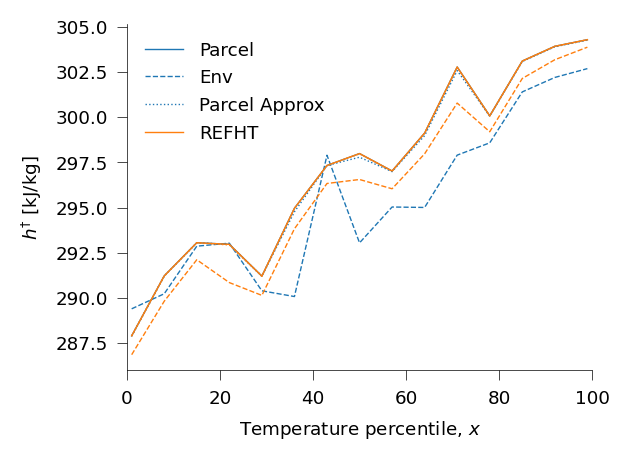

5.78836534259608e-10


In [21]:
tau_lw_plot = 0
surf_plot = 0
lat_plot = 0
sample_plot = 0
fig, ax = plt.subplots(1, 1)
fig_resize(fig, 3)
ax.plot(ds_quant.quant, mse_mod_ft_parcel.isel(surf=surf_plot, lat=lat_plot, sample=sample_plot, tau_lw=tau_lw_plot),
        label='Parcel',
        color='C0')
ax.plot(ds_quant.quant, mse_mod_ft_env.isel(surf=surf_plot, lat=lat_plot, sample=sample_plot, tau_lw=tau_lw_plot),
        label='Env', color='C0',
        linestyle='--')
ax.plot(ds_quant.quant,
        mse_mod_ft_parcel_approx.isel(surf=surf_plot, lat=lat_plot, sample=sample_plot, tau_lw=tau_lw_plot),
        label='Parcel Approx', color='C0', linestyle=':')

ax.plot(ds_quant.quant, mse_mod_REFHT_parcel.isel(surf=surf_plot, lat=lat_plot, sample=sample_plot, tau_lw=tau_lw_plot),
        label='REFHT',
        color='C1')
ax.plot(ds_quant.quant, mse_mod_REFHT_env.isel(surf=surf_plot, lat=lat_plot, sample=sample_plot, tau_lw=tau_lw_plot),
        color='C1',
        linestyle='--')
ax.plot(ds_quant.quant,
        mse_mod_REFHT_parcel_approx.isel(surf=surf_plot, lat=lat_plot, sample=sample_plot, tau_lw=tau_lw_plot),
        color='C1', linestyle=':')

ax.legend()
ax.set_xlabel('Temperature percentile, $x$')
ax.set_ylabel('$h^{\dagger}$ [kJ/kg]')
update_fontsize(fig, 7)
ax.set_xlim(0, 100)
plt.show()

# Sanity check that parcel mod MSE is the same at surface and parcel
print(float(np.abs(mse_mod_REFHT_parcel - mse_mod_ft_parcel).max()))

# ax.plot(ds_quant.quant, mse_mod_REFHT_parcel.isel(sample=0, surf=0, lat=0))
# plt.plot(ds_quant.quant, mse_mod_ft_env.isel(sample=0, surf=0, lat=0))
# plt.plot(ds_quant.quant, mse_mod_ft_parcel_approx.isel(sample=0, surf=0, lat=0))

In [22]:
epsilon_theory = (mse_mod_ft_parcel_approx - mse_mod_ft_env) - (mse_mod_REFHT_parcel_approx - mse_mod_REFHT_env)
epsilon_error = -z_error + mse_mod_ft_parcel_error - mse_mod_REFHT_parcel_error

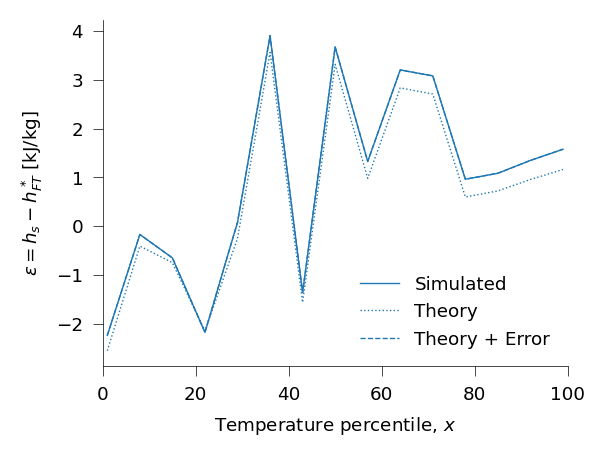

6.143463131280669e-05


In [23]:
fig, ax = plt.subplots(1, 1)
fig_resize(fig, 3)
ax.plot(ds_quant.quant, epsilon.isel(surf=surf_plot, lat=lat_plot, sample=sample_plot, tau_lw=tau_lw_plot),
        label='Simulated', color='C0')
ax.plot(ds_quant.quant, epsilon_theory.isel(surf=surf_plot, lat=lat_plot, sample=sample_plot, tau_lw=tau_lw_plot),
        label='Theory',
        color='C0', linestyle=':')
ax.plot(ds_quant.quant,
        (epsilon_theory + epsilon_error).isel(surf=surf_plot, lat=lat_plot, sample=sample_plot, tau_lw=tau_lw_plot),
        label='Theory + Error',
        color='C0', linestyle='--')

ax.legend()
ax.set_xlabel('Temperature percentile, $x$')
ax.set_ylabel('$\epsilon = h_s - h_{FT}^*$ [kJ/kg]')
update_fontsize(fig, 7)
ax.set_xlim(0, 100)
plt.show()

# Sanity check that theory and error are exact
print(float(np.abs(epsilon - (epsilon_theory + epsilon_error)).max()))

### Decomposition of $\epsilon$ contributions
Given the above theory for $\epsilon$, we now decompose the contribution due to each physical variable: $T_s, T_{FT}, r_s, p_s, \eta_D, \eta_M$.

By definition, $\epsilon=0$ if $\eta_D = \eta_M = 0$. So we only consider the actual values of $\eta_D$ and $\eta_M$, then consider the non linear contributions from variation of other parameters too.

In [24]:
def get_epsilon_theory(temp_surf, temp_ft, rh_surf, p_surf, lapse_diff_D, lapse_diff_M, p_ft=p_ft,
                       temp_lcl_ref=temp_lcl_bolton_use):
    R_mod, _, _, beta_ft1, _, _, _ = get_theory_prefactor_terms(temp_ft, p_surf, p_ft)
    beta_s1 = get_theory_prefactor_terms(temp_surf, p_surf, p_ft, sphum=rh_surf * sphum_sat(temp_surf, p_surf))[3]
    exponent_use = R * lapse_diff_M / g
    sigma_lcl = lcl_sigma_bolton_simple(rh_surf, temp_lcl_ref)
    sigma_ft = p_ft / p_surf
    if do_taylor_expansion:
        cont_ft = beta_ft1 * temp_ft * exponent_use * np.log(sigma_lcl / sigma_ft)
    else:
        cont_ft = beta_ft1 * (sigma_lcl ** exponent_use * sigma_ft ** (-exponent_use) - 1) * temp_ft
    exponent_use = R * lapse_diff_D / g
    if do_taylor_expansion:
        cont_surf = beta_s1 * temp_surf * exponent_use * np.log(sigma_lcl)
    else:
        cont_surf = beta_s1 * (sigma_lcl ** exponent_use - 1) * temp_surf
    return (cont_ft - cont_surf) / 1000


def get_epsilon_error(temp_surf, temp_ft, rh_surf, p_surf, lapse_diff_D, lapse_diff_M, p_ft=p_ft,
                      temp_lcl_ref=temp_lcl_bolton_use):
    # Returns the error terms combined as A_p = A_{FT,p} - A{s,p}
    # Ignores the z error term
    sigma_lcl = lcl_sigma_bolton_simple(rh_surf, temp_lcl_ref)
    sigma_ft = p_ft / p_surf
    exponent_use = R * lapse_diff_M / g
    temp_ft_parcel = temp_ft * sigma_lcl ** exponent_use * sigma_ft ** (-exponent_use)
    exponent_use = R * lapse_diff_D / g
    temp_surf_parcel = temp_surf * sigma_lcl ** exponent_use

    mse_mod_ft_parcel = ((c_p + R_mod) * temp_ft_parcel + L_v * sphum_sat(temp_ft_parcel, p_ft))
    mse_mod_ft_env = ((c_p + R_mod) * temp_ft + L_v * sphum_sat(temp_ft, p_ft))

    mse_mod_surf_parcel = ((c_p - R_mod) * temp_surf_parcel + L_v * rh_surf * sphum_sat(temp_surf_parcel, p_surf))
    mse_mod_surf_env = ((c_p - R_mod) * temp_surf + L_v * rh_surf * sphum_sat(temp_surf, p_surf))

    epsilon_exact = ((mse_mod_ft_parcel - mse_mod_ft_env) - (mse_mod_surf_parcel - mse_mod_surf_env)) / 1000
    epsilon_theory = get_epsilon_theory(temp_surf, temp_ft, rh_surf, p_surf, lapse_diff_D, lapse_diff_M, p_ft,
                                        temp_lcl_bolton_use)
    return epsilon_exact - epsilon_theory


var = get_epsilon_theory(ds_quant.TREFHT, ds_quant.T_ft_env, ds_quant.rh_REFHT, ds_quant.PREFHT,
                         ds_quant.mod_parcel1_lapse.isel(layer=0) / 1000 - lapse_dry,
                         ds_quant.mod_parcel1_lapse.isel(layer=1) / 1000)
print(float(np.abs(var - epsilon_theory).max()))

var = get_epsilon_error(ds_quant.TREFHT, ds_quant.T_ft_env, ds_quant.rh_REFHT, ds_quant.PREFHT,
                        ds_quant.mod_parcel1_lapse.isel(layer=0) / 1000 - lapse_dry,
                        ds_quant.mod_parcel1_lapse.isel(layer=1) / 1000)
print(float(np.abs(var - (mse_mod_ft_parcel_error - mse_mod_REFHT_parcel_error)).max()))

6.084022174945858e-14
1.9504723161034576e-06


### Single Climate
Here, I look at what causes variation across quantiles of $\epsilon$ within a single climate.

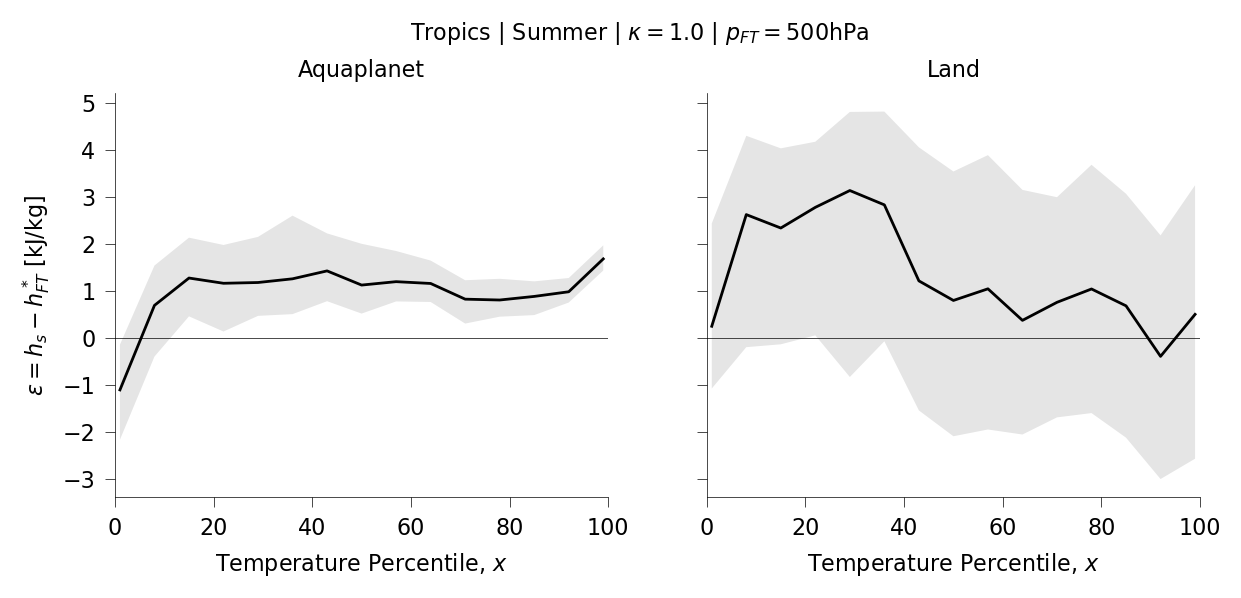

In [25]:
lat_weights = np.cos(np.deg2rad(ds.lat))
percentile_label = 'Temperature Percentile, $x$'

tau_lw_ind = 0
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 7)
for k in range(ds.surf.size):
    ax[k].set_title(ds_quant.surf.values[k].capitalize())
    ax[k].plot(ds_quant.quant,
               np.average(epsilon_theory.isel(surf=k, tau_lw=tau_lw_ind).quantile(0.5, dim='sample'), axis=1,
                          weights=lat_weights),
               color='k')
    ax[k].fill_between(ds_quant.quant,
                       np.average(epsilon_theory.isel(surf=k, tau_lw=tau_lw_ind).quantile(0.25, dim='sample'), axis=1,
                                  weights=lat_weights),
                       np.average(epsilon_theory.isel(surf=k, tau_lw=tau_lw_ind).quantile(0.75, dim='sample'), axis=1,
                                  weights=lat_weights), alpha=0.1, color='k', edgecolor="none")

update_linewidth(fig)
fig.suptitle(
    f"{region.capitalize()} | {season.capitalize()} | $\kappa = {ds_quant.tau_lw.values[tau_lw_ind]}$ | $p_{'{FT}'} = {p_ft / 100:.0f}$hPa",
    y=1.02)
update_fontsize(fig)
ax[0].set_ylabel('$\epsilon = h_s - h_{FT}^*$ [kJ/kg]')
ax[0].set_xlabel(percentile_label)
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
for k in range(ds.surf.size):
    ax[k].axhline(0, color='k', lw=ax_linewidth)
plt.show()

In [26]:
ds_quant['lapse_diff_D'] = ds_quant.mod_parcel1_lapse.isel(layer=0) / 1000 - lapse_dry
ds_quant['lapse_diff_M'] = ds_quant.mod_parcel1_lapse.isel(layer=1) / 1000

ds_ref = ds_quant[['TREFHT', 'rh_REFHT', 'PREFHT']].median(dim=['sample', 'quant'])
# Ensure ref values of rh and P have same value for all tau_lw. Set to coldest simulation
ds_ref['rh_REFHT'] = ds_ref['rh_REFHT'] * 0 + ds_ref['rh_REFHT'].isel(tau_lw=0)
ds_ref['PREFHT'] = ds_ref['PREFHT'] * 0 + ds_ref['PREFHT'].isel(tau_lw=0)
# Compute T_ft assuming perfectly SQE
ds_ref['T_ft_env'] = xr.apply_ufunc(get_temp_adiabat, ds_ref.TREFHT,
                                    ds_ref.rh_REFHT * sphum_sat(ds_ref['TREFHT'], ds_ref.PREFHT),
                                    ds_ref.PREFHT,
                                    input_core_dims=[[], [], []], vectorize=True, kwargs={'pressure_ft': p_ft})
# For lapse rate params, ref value cannot be zero, but make it the value in the colder simulation
ds_ref['lapse_diff_D'] = ds_quant['lapse_diff_D'].isel(tau_lw=0)
ds_ref['lapse_diff_M'] = ds_quant['lapse_diff_M'].isel(tau_lw=0)

In [27]:
ds_eps = ds_quant[['TREFHT']]
ds_eps['lapse_D'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                       ds_quant['lapse_diff_D'], 0)
ds_eps['lapse_M'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                       0, ds_quant['lapse_diff_M'])
ds_eps = ds_eps.drop_vars('TREFHT')

ds_eps['TREFHT'] = get_epsilon_theory(ds_quant.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                      ds_quant['lapse_diff_D'], ds_quant['lapse_diff_M'])
ds_eps['TREFHT'] = ds_eps['TREFHT'] - ds_eps['lapse_D'] - ds_eps['lapse_M']

ds_eps['T_ft_env'] = get_epsilon_theory(ds_ref.TREFHT, ds_quant.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                        ds_quant['lapse_diff_D'], ds_quant['lapse_diff_M'])
ds_eps['T_ft_env'] = ds_eps['T_ft_env'] - ds_eps['lapse_D'] - ds_eps['lapse_M']

ds_eps['rh_REFHT'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_quant.rh_REFHT, ds_ref.PREFHT,
                                        ds_quant['lapse_diff_D'], ds_quant['lapse_diff_M'])
ds_eps['rh_REFHT'] = ds_eps['rh_REFHT'] - ds_eps['lapse_D'] - ds_eps['lapse_M']

ds_eps['PREFHT'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_quant.PREFHT,
                                      ds_quant['lapse_diff_D'], ds_quant['lapse_diff_M'])
ds_eps['PREFHT'] = ds_eps['PREFHT'] - ds_eps['lapse_D'] - ds_eps['lapse_M']

ds_eps = ds_eps.transpose('quant', 'surf', 'tau_lw', 'lat', 'sample')


In [28]:
ds_eps2 = copy.deepcopy(ds_eps)
eps2_ref_cont = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT,
                                   ds_ref.PREFHT, ds_ref['lapse_diff_D'], ds_ref['lapse_diff_M'])
ds_eps2['TREFHT'] = get_epsilon_theory(ds_quant.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                       ds_ref['lapse_diff_D'], ds_ref['lapse_diff_M']) - eps2_ref_cont

ds_eps2['T_ft_env'] = get_epsilon_theory(ds_ref.TREFHT, ds_quant.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                         ds_ref['lapse_diff_D'], ds_ref['lapse_diff_M']) - eps2_ref_cont

ds_eps2['rh_REFHT'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_quant.rh_REFHT, ds_ref.PREFHT,
                                         ds_ref['lapse_diff_D'], ds_ref['lapse_diff_M']) - eps2_ref_cont

ds_eps2['PREFHT'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_quant.PREFHT,
                                       ds_ref['lapse_diff_D'], ds_ref['lapse_diff_M']) - eps2_ref_cont

ds_eps2 = ds_eps2.transpose('quant', 'surf', 'tau_lw', 'lat', 'sample')

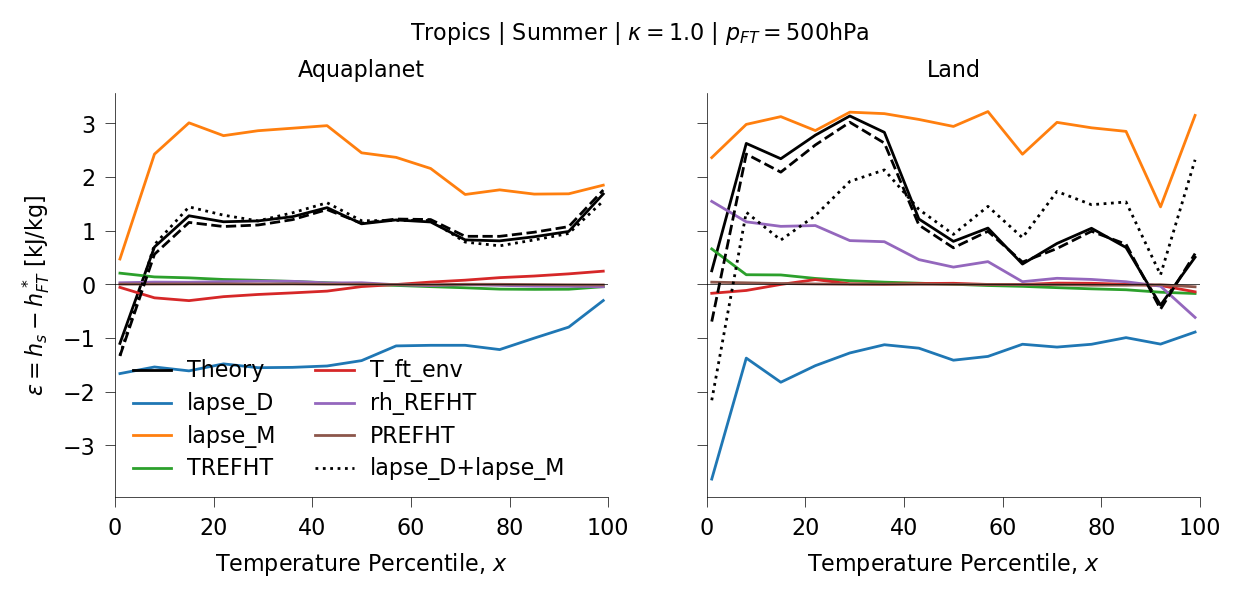

In [29]:
tau_lw_ind = 0
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 7)
for k in range(ds.surf.size):
    ax[k].set_title(ds_quant.surf.values[k].capitalize())
    ax[k].plot(ds_quant.quant,
               np.average(epsilon_theory.isel(surf=k, tau_lw=tau_lw_ind).quantile(0.5, dim='sample'), axis=1,
                          weights=lat_weights),
               color='k', label='Theory')
    for j, key in enumerate(ds_eps):
        ax[k].plot(ds_quant.quant,
                   np.average(ds_eps[key].isel(surf=k, tau_lw=tau_lw_ind).quantile(0.5, dim='sample'), axis=1,
                              weights=lat_weights),
                   color=f'C{j}', label=key)
    ax[k].plot(ds_quant.quant, np.average(
        (ds_eps['lapse_D'] + ds_eps['lapse_M']).isel(surf=k, tau_lw=tau_lw_ind).quantile(0.5, dim='sample'),
        axis=1, weights=lat_weights), color=f'k', linestyle=':', label='lapse_D+lapse_M')
    ax[k].plot(ds_quant.quant,
               np.average((ds_eps['lapse_D'] + ds_eps['lapse_M'] + ds_eps['rh_REFHT'] + ds_eps['T_ft_env']
                           ).isel(surf=k, tau_lw=tau_lw_ind).quantile(0.5, dim='sample'),
                          axis=1, weights=lat_weights), color=f'k', linestyle='--')
# ax[k].fill_between(ds_quant.quant, np.average(epsilon_theory.isel(surf=k).quantile(0.25, dim='sample'), axis=1,
#                                               weights=lat_weights),
#                    np.average(epsilon_theory.isel(surf=k).quantile(0.75, dim='sample'), axis=1,
#                               weights=lat_weights), alpha=0.1, color='k', edgecolor="none")
update_linewidth(fig)
ax[0].legend(ncol=2)
fig.suptitle(
    f"{region.capitalize()} | {season.capitalize()} | $\kappa = {ds_quant.tau_lw.values[tau_lw_ind]}$ | $p_{'{FT}'} = {p_ft / 100:.0f}$hPa",
    y=1.02)
update_fontsize(fig)
ax[0].set_ylabel('$\epsilon = h_s - h_{FT}^*$ [kJ/kg]')
ax[0].set_xlabel(percentile_label)
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
for k in range(ds.surf.size):
    ax[k].axhline(0, color='k', lw=ax_linewidth)
plt.show()

### Change between simulations
Here, I look at how the above contributions change with warming.

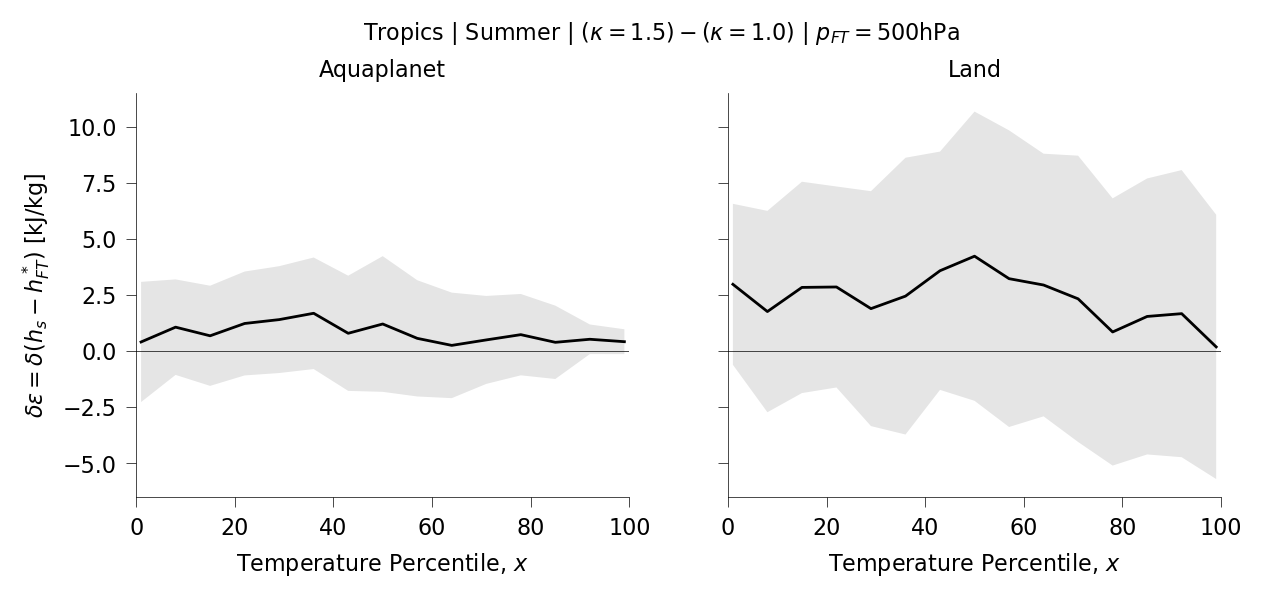

In [30]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 7)
for k in range(ds.surf.size):
    ax[k].set_title(ds_quant.surf.values[k].capitalize())
    var = epsilon_theory.isel(surf=k).quantile(0.5, dim='sample')
    ax[k].plot(ds_quant.quant,
               np.average(var.isel(tau_lw=1) - var.isel(tau_lw=0), axis=1, weights=lat_weights),
               color='k')
    error = np.sqrt(epsilon_theory.isel(surf=k, tau_lw=0).std(dim='sample') ** 2 +
                    epsilon_theory.isel(surf=k, tau_lw=1).std(dim='sample') ** 2)
    ax[k].fill_between(ds_quant.quant, np.average(var.isel(tau_lw=1) - var.isel(tau_lw=0) - error, axis=1,
                                                  weights=lat_weights),
                       np.average(var.isel(tau_lw=1) - var.isel(tau_lw=0) + error, axis=1,
                                  weights=lat_weights), alpha=0.1, color='k', edgecolor="none")

update_linewidth(fig)
fig.suptitle(
    f"{region.capitalize()} | {season.capitalize()} | $(\kappa = {ds_quant.tau_lw.values[1]}) - (\kappa = {ds_quant.tau_lw.values[0]})$ | "
    f"$p_{'{FT}'} = {p_ft / 100:.0f}$hPa", y=1.02)
update_fontsize(fig)
ax[0].set_ylabel('$\delta \epsilon = \delta (h_s - h_{FT}^*)$ [kJ/kg]')
ax[0].set_xlabel(percentile_label)
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
for k in range(ds.surf.size):
    ax[k].axhline(0, color='k', lw=ax_linewidth)
plt.show()

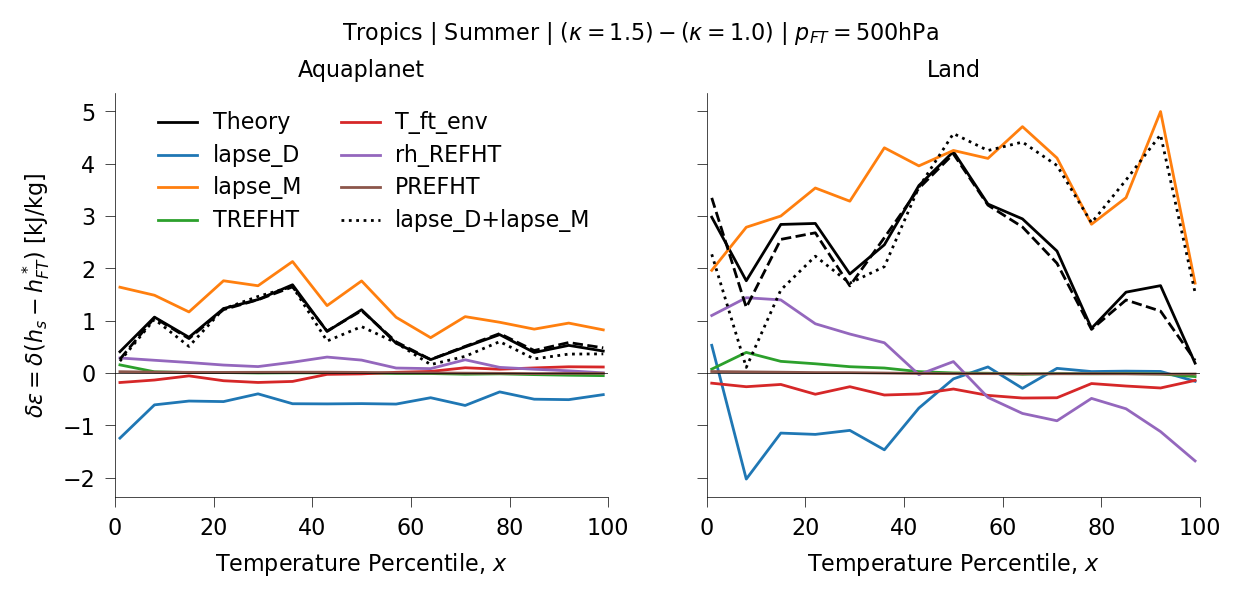

In [31]:
ds_use = ds_eps
# ds_use = ds_eps2        # For non-linear cont, takes colder sim value of lapse diff params
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 7)
for k in range(ds.surf.size):
    ax[k].set_title(ds_quant.surf.values[k].capitalize())
    var = epsilon_theory.isel(surf=k).quantile(0.5, dim='sample')
    ax[k].plot(ds_quant.quant,
               np.average(var.isel(tau_lw=1) - var.isel(tau_lw=0), axis=1, weights=lat_weights),
               color='k', label='Theory')
    for j, key in enumerate(ds_eps):
        ax[k].plot(ds_quant.quant,
                   np.average(ds_use[key].isel(surf=k, tau_lw=1).quantile(0.5, dim='sample') -
                              ds_use[key].isel(surf=k, tau_lw=0).quantile(0.5, dim='sample'), axis=1,
                              weights=lat_weights),
                   color=f'C{j}', label=key)
    var = (ds_use['lapse_D'] + ds_use['lapse_M']).quantile(0.5, dim='sample').isel(surf=k)
    ax[k].plot(ds_quant.quant, np.average(
        var.isel(tau_lw=1) - var.isel(tau_lw=0),
        axis=1, weights=lat_weights), color=f'k', linestyle=':', label='lapse_D+lapse_M')
    var = (ds_use['lapse_D'] + ds_use['lapse_M'] + ds_use['rh_REFHT'] + ds_use['T_ft_env']).quantile(0.5,
                                                                                                         dim='sample').isel(
        surf=k)
    ax[k].plot(ds_quant.quant, np.average(var.isel(tau_lw=1) - var.isel(tau_lw=0),
                                          axis=1, weights=lat_weights), color=f'k', linestyle='--')

update_linewidth(fig)
ax[0].legend(ncol=2)
fig.suptitle(
    f"{region.capitalize()} | {season.capitalize()} | $(\kappa = {ds_quant.tau_lw.values[1]}) - (\kappa = {ds_quant.tau_lw.values[0]})$ | "
    f"$p_{'{FT}'} = {p_ft / 100:.0f}$hPa", y=1.02)
update_fontsize(fig)
ax[0].set_ylabel('$\delta \epsilon = \delta (h_s - h_{FT}^*)$ [kJ/kg]')
ax[0].set_xlabel(percentile_label)
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
for k in range(ds.surf.size):
    ax[k].axhline(0, color='k', lw=ax_linewidth)
plt.show()